# Light curve Anomaly Identification & Similarity Search (LAISS) Tutorial
### written by Patrick Aleo and Alex Gagliano (gaglian2@mit.edu)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alexandergagliano/laiss_timedomainanomalies/blob/main/notebooks/01_laiss_demo.ipynb)

LAISS is a tool to consolidate the photometric features of supernovae and the galaxies that host them, and use these properties to find similar supernovae and identify anomalies. 

There are many definitions for what constitutes an anomaly. In this hack, our goal is to pull out supernovae that exhibit rare photometric behavior (such as phases of re-brightening) and unusual contextual (a supernova in a galaxy we don't expect, such as the explosion of a young star in a galaxy full of older stars).

The similarity search takes advantage of [Approximate Nearest Neighbors Oh Yeah (ANNOY)](https://github.com/spotify/annoy), the approximate nearest neighbors algorithm developed by Spotify that allows you to come up with a relevant song to listen to before your current one ends. The anomaly detection classifier is a random forest trained on manually-vetted anomalous and "typical" supernovae. The design and validation of the LAISS framework is explained in detail in [Aleo et al., 24](https://arxiv.org/html/2404.01235v1). 

Note that this code assumes that the supernova photometry passed in is $g$ and $R$-band photometry from the Zwicky Transient Facility! Accomodating other survey data will likely require some re-training.

We've moved the bulk of the code into two associated files (`helper_functions.py` and `laiss_functions.py` for simplicity). Let's start by installing and loading the relevant packages:

In [ ]:
#if running in a linux environment (including colab), you'll need the following command for the antares client to install:
!sudo apt-get install librdkafka-dev -y

#another command in colab to get the associated code from the repo
!git clone https://github.com/alexandergagliano/laiss_timedomainanomalies.git
%cd laiss_timedomainanomalies/notebooks

In [3]:
!pip install numpy pandas pillow astro_ghost timeout_decorator astropy gdown astropy confluent-kafka antares_client matplotlib light_curve annoy scikit-learn

In [11]:
import os

#a silly hack to switch the working directory to the one where this file is located
working_dir = os.path.abspath("")

import time
import datetime
import math
import numpy as np
import pandas as pd
import sys 
import os 
import subprocess

os.chdir(working_dir)
sys.path.append('../code/')

from helper_functions import *
from laiss_functions import *

import requests
from requests.auth import HTTPBasicAuth

import warnings
warnings.filterwarnings("ignore")

Let's also download and unpack the data we need for this tutorial: 

In [4]:
!gdown -O ../ 131frC1TmAUenZewuHuY2wuOpXLyUji0m
!unzip -o ../data.zip -d ../

Downloading...
From: https://drive.google.com/uc?id=131frC1TmAUenZewuHuY2wuOpXLyUji0m
To: /Users/alexgagliano/Documents/Research/LAISS/laiss_package/data.zip
100%|████████████████████████████████████████| 225M/225M [00:03<00:00, 59.4MB/s]
Archive:  ../data.zip
  inflating: ../data/lc_features.txt  
  inflating: ../data/dataset_bank_orig_5472objs.csv.gz  
  inflating: ../data/loci_df_271688objects_cut_stars_and_gal_plane.csv  
  inflating: ../data/dataset_bank_orig_w_hosts_ra_dec_5472objs.csv.gz  
  inflating: ../data/host_features.txt  


We can choose the features of both the host galaxy and the supernova light curve to use in our matching algorithm. In this case, we've taken the same features as the original code, and stored them in the files `host_features.txt` and `lc_features.txt`.

In [26]:
with open("../data/host_features.txt") as host_f:
    host_features = [line.strip() for line in host_f.readlines()]


with open("../data/lc_features.txt") as lc_f:
    lc_features = [line.strip() for line in lc_f.readlines()]

lc_and_host_features = host_features + lc_features

Next, we can choose the hyperparameters for our anomaly detection classifier. We can choose `n_estimators`, the number of trees in our model; `max_depth`, the largest a decision tree can grow in the forest; `random_state`, set to a fixed value for reproducibility; and `max_features`, the total number of features to consider at each split in the decision tree.

In [15]:
# Hyperparameters for best AD model
n_estimators = 100
max_depth = 35
random_state = 11
max_features = 35

ANNOY is such an efficient similarity search because it uses _locality-sensitive hashing_. Let's say we want to distinguish supernovae by two features, brightness at peak and characteristic timescale. We can start to distinguish events by picking two events at random, and throwing down a line that separates them in this space. Then, we can assign every event a number based on which side of the line it falls: 0 if it falls to one side and 1 if it falls to the other:  

![annoy_1](../assets/ANNOY_1.png)

This isn't super useful for finding meaningful groups in the data, so let's repeat the process. We'll again pick two random points, but this time they'll both be on one side of the first line. We'll assign another binary digit to every event that falls on this side or the other: 

![annoy_2](../assets/ANNOY_2.png)

We continue the process several more times, carving up the space with randomly-placed separating lines and adding a binary digit to the event's assigned code:  
![](../assets/ANNOY_3.png)

If we've done this enough times, we can use the binary code (a _hash code_) of each leaf in our constructed tree _to represent all the events with the same code_. This is a compression technique: the supernovae at each leaf will have slightly different peak brightnesses and timescale. 

The value in creating this indexed space lies in fast neighbor searches: instead of measuring the distance between a queried supernova and every reference supernova, we can calculate how the queried supernova would traverse this indexed space and pull _n_ events at the same leaf:

![](../assets/ANNOY_4.png)

This ends of being _significantly_ faster than traditional nearest-neighbors approaches, though slightly less accurate. You can also imagine repeating this process several times and taking nearest neighbors from several different randomly-constructed indexed spaces: 

![](../assets/ANNOY_5.png)

For more than two parameters, ANNOY calculates the dot product between two randomly-selected vectors and a separating hyperplane between them. If the dot product is negative, the vector is on one side, if it's positive, it's on the other. The rest of the story is the same.

![](../assets/ANNOY_6.png)

Now let's dig into the code. First, we have to get ANNOY to build up the indexed space of supernova features for many reference events. We input the features we want to index and the data. 

In [5]:
%%time
build_indexed_sample(fn='../data/loci_df_271688objects_cut_stars_and_gal_plane.csv', lc_features=lc_features, host_features=[], pca=False, save=True)

Loading previously saved ANNOY index
CPU times: user 4.71 s, sys: 373 ms, total: 5.09 s
Wall time: 5.1 s


To make this process a little faster, we can instead reduce the number of features we want to index by running principal component analysis on the raw data. By default, this compresses the space down to 60 parameters that are linear combinations of the light curve + host features. With the fiducial host + lc features chosen here, 60 PCs retains 98% of the original data variance.

In [6]:
%%time
# Load the spec & phot dataset_bank used for train/test (before upsampling w/ SMOTE)
# All real events

build_indexed_sample(fn='../data/dataset_bank_orig_5472objs.csv.gz', lc_features=lc_features, host_features=host_features, pca=True, save=True)

Loading previously saved ANNOY index
CPU times: user 5.7 s, sys: 1.2 s, total: 6.9 s
Wall time: 784 ms


Now we run our main function, `LAISS`. There are a few different inputs to the function: 
* `l_or_ztfid_ref`: The ANTARES or ZTF name for the transient to query. By default, the photometry is retrieved as the first step in the pipeline.
* `lc_features`: The light curve features used in the similarity search. 
* `host_features`: The host-galaxy features used in the similarity search.
* `n`: The number of neighbors to retrieve using ANNOY.
* `use_lc_for_ann_only_bool`: Only uses photometry for the similarity search. This could easily be removed!
* `use_ysepz_phot_snana_file`: Instead of retrieving photometry from the ANTARES website, it can be supplied manually in the `timeseries` folder. 
* `show_lightcurves_grid` and `show_hosts_grid`: Shows the neighbors matched to the queried supernova. 
* `run_AD_model`: Additionally runs the random forest classifier to determine an anomaly score of the event at each observation. This requires both light curve and galaxy features to be calculated!
* `savetables`: Saves the intermediate data from the run.
* `savefigs`: Saves the generated figures. 
*  `ad_params`: The parameters of the specific anomaly detection classifier to load (these will always stay the same, unless we re-train the classifier). 

Running LAISS...
ZTF21aaublej is in dataset_bank
trained_PCA_feat_arr
(5472, 120)
locus_feat_arr
(120,)
Loading previously saved ANNOY LC+HOST PCA=60 index
./data/dataset_bank_orig_5472objs_pcaTrue_hostTrue_annoy_index.ann
					   ZTFID IAU_NAME SPEC Z
REF. : https://alerce.online/object/ZTF21aaublej 2021ixf SN Ia 0.041
ANN=1: https://alerce.online/object/ZTF21abbkefe 2021mid SN Ia, 0.041542
ANN=2: https://alerce.online/object/ZTF21aafgljq 2021ars SN Ia, 0.05
ANN=3: https://alerce.online/object/ZTF20abqaqgv 2020qqn SN Ia, 0.045
ANN=4: https://alerce.online/object/ZTF21absvlrr 2021vtq SN Ia, 0.0208
ANN=5: https://alerce.online/object/ZTF20acucbek 2020abcl SN Ia, 0.03889
ANN=6: https://alerce.online/object/ZTF20aczgoml 2020adis SN Ia-91T-like, 0.0453189984
ANN=7: https://alerce.online/object/ZTF21abrxoir 2021vju SN Ia, 0.026657
ANN=8: https://alerce.online/object/ZTF21abqsysj 2021vpv SN Ia-91T-like, 0.04

ANN elapsed_time = 0.004 s

total elapsed_time = 7.354 s


Running AD Model!...
Nee

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF21aaublej


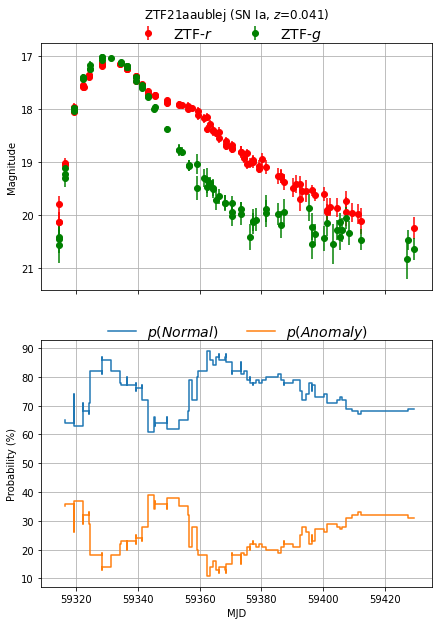

In [8]:
LAISS(l_or_ztfid_ref="ZTF21aaublej",  # ZTF21aaublej
      lc_features=lc_features,
      host_features=host_features,
      n=8,
      use_lc_for_ann_only_bool=False, # currently doesn't work with YSE_snana_format or ANT IDs 
      use_ysepz_phot_snana_file=False,
      show_lightcurves_grid=False,
      show_hosts_grid=False,
      run_AD_model=True, #needs host feats for AD model!
      savetables=False,
      savefigs=False, 
     ad_params={'n_estimators':n_estimators, 'max_depth':max_depth, 'random_state':random_state, 'max_features':max_features})

Though LAISS is fast and runs in real-time, it tends to pick out long-lived transients because it cannot run if any of the selected features are missing. This is a limitation! The main questions that we hope to address through this hack are: 

1. *How well does LAISS do at finding relevant/unusual supernovae before peak brightness?* The earlier we find an unusual event, the more time we have to follow it up with complementary observing resources. 
2. *How can we change the architecture to improve its ability to pick out strange supernovae earlier?* Should a sub-set of existing features be used, or would a more flexible light curve and host galaxy encoder work better? 

That's all for now!